# Example: the causal effect variational autoencoder

In [36]:
from typing import Callable, Dict, List, Optional, Tuple, Union, TypeVar

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.infer.util import torch_item
from pyro.nn import PyroModule, PyroSample, PyroParam
from pyro.contrib.autoname import scope
from pyro.poutine import condition, reparam
from pyro.optim import ClippedAdam
from pyro.util import torch_isnan

import causal_pyro
from causal_pyro.query.do_messenger import do
from causal_pyro.counterfactual.handlers import Factual, MultiWorldCounterfactual, TwinWorldCounterfactual


## Background: Proxy variables and latent confounders

The backdoor adjustment example assumed that it was always possible to measure all
potential confounders $X$, but when this is not the case, additional
assumptions are necessary to perform causal inference. This example,
derived from @louizos2017causal, considers a setting where parametric
assumptions are necessary for a causal model to be fully identifiable
from observed data.

Suppose we observe a population of individuals with features $X_i$
undergo treatment $t_i \in \{0, 1\}$ with outcome $y_i$. The treatment
variable might represent a medication or an educational strategy, for
example, for populations of patients or students, respectively.

The task
is to estimate the *conditional average treatment effect*: for a new
individual with features $X_*$, what difference in outcome $y_*$ should
we expect if we assign treatment $t_* = 1$ vs. $t_* = 0$? One cannot
simply estimate the conditional probabilities
$p(y_* \mid X = X_*, t = 0)$ and $p(y_* \mid X = X_*, t = 1)$, because
there may be hidden confounders: latent factors $z$ that induce
non-causal correlations between $t$ and $y$ even controlling for the
observed covariates $X$. 

For example, a student's socio-economic status
might influence both their outcome $y$ and the educational strategy $t$
they are exposed to, and the observed covariates $X$ may not fully
characterize the student's SES. As a result, conditioning on $t$ may
alter the distribution over SES, changing the reported outcome.



In [37]:
num_data = 1000
feature_dim = 5

def generate_data(num_data, feature_dim):

    z = dist.Bernoulli(0.5).sample([num_data])
    x = dist.Normal(z, 5 * z + 3 * (1 - z)).sample([feature_dim]).t()
    t = dist.Bernoulli(0.75 * z + 0.25 * (1 - z)).sample()
    y = dist.Bernoulli(logits=3 * (z + 2 * (2 * t - 2))).sample()

    # Compute true ite for evaluation (via Monte Carlo approximation).
    t0_t1 = torch.tensor([[0.0], [1.0]])
    y_t0, y_t1 = dist.Bernoulli(logits=3 * (z + 2 * (2 * t0_t1 - 2))).mean
    true_ite = y_t1 - y_t0
    return x, t, y, true_ite


x, t, y, true_ite = generate_data(num_data, feature_dim)

## Model: neural surrogate causal Bayesian network

Our model captures the intuition that our three observed variables, $X$,
$t$, and $y$, may be correlated, thanks to unobserved confounders $z$.
Here, $f$, $g$, and $h$ are neural networks parameterized by different
parts of the parameter set $\theta$. The parameters of our model can be fit
using standard techniques in Pyro (e.g., stochastic variational
inference).

In [38]:
class FullyConnected(nn.Sequential):
    def __init__(self, sizes):
        layers = []
        for in_size, out_size in zip(sizes, sizes[1:]):
            layers.append(nn.Linear(in_size, out_size))
            layers.append(nn.ELU())
        layers.pop(-1)
        super().__init__(*layers)


class DiagNormalNet(FullyConnected):
    def __init__(self, sizes):
        assert len(sizes) >= 2
        sizes = sizes[:-1] + [sizes[-1] * 2]
        super().__init__(sizes)

    def forward(self, x):
        loc, scale = super().forward(x).chunk(2, dim=-1)
        return loc, nn.functional.softplus(scale)


class BernoulliNet(FullyConnected):
    def __init__(self, sizes):
        super().__init__(sizes + [1])

    def forward(self, x):
        return super().forward(x).squeeze(-1).clamp(min=-10, max=10)

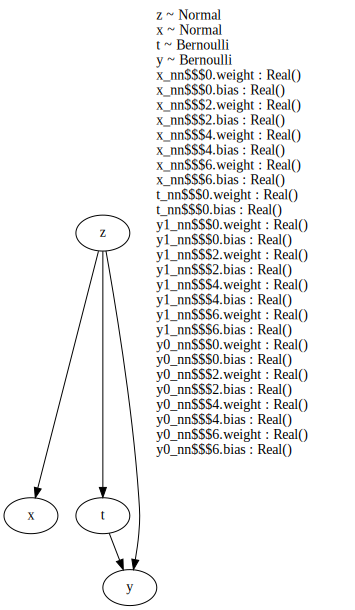

In [39]:
class ProxyConfounderModel(PyroModule):
    """
    :param dict config: A dict specifying ``feature_dim``, ``latent_dim``,
        ``hidden_dim``, ``num_layers``, and ``outcome_dist``.
    """

    def __init__(self, config):
        self.latent_dim = config["latent_dim"]
        self.hidden_dim = config["hidden_dim"]
        self.num_layers = config["num_layers"]
        self.outcome_dist = config["outcome_dist"]
        self.feature_dim = config["feature_dim"]
        super().__init__()
        self.x_nn = DiagNormalNet(
            [config["latent_dim"]]
            + [config["hidden_dim"]] * config["num_layers"]
            + [config["feature_dim"]]
        )
        if config["outcome_dist"] == "bernoulli":
            OutcomeNet = BernoulliNet
        else:
            raise NotImplementedError(config["outcome_dist"])
        # The y network is split between the two t values.
        self.y0_nn = OutcomeNet(
            [config["latent_dim"]] + [config["hidden_dim"]] * config["num_layers"]
        )
        self.y1_nn = OutcomeNet(
            [config["latent_dim"]] + [config["hidden_dim"]] * config["num_layers"]
        )
        self.t_nn = BernoulliNet([config["latent_dim"]])

    def forward(self):
        z = pyro.sample("z", dist.Normal(0, 1).expand([self.latent_dim]).to_event(1))
        x = pyro.sample("x", dist.Normal(*self.x_nn(z)).to_event(1))
        t = pyro.sample("t", dist.Bernoulli(logits=self.t_nn(z)))
        # parameters are not shared among values of t
        y_logits = torch.where(t == 1, self.y1_nn(z), self.y0_nn(z))
        y = pyro.sample("y", dist.Bernoulli(logits=y_logits))
        return y


individual_model = ProxyConfounderModel(dict(
    feature_dim=x.shape[-1],
    latent_dim=20,
    hidden_dim=200,
    num_layers=3,
    num_samples=20,
    outcome_dist="bernoulli",
))
pyro.render_model(individual_model, model_args=(), render_distributions=True, render_params=True)

## Query: conditional average treatment effect (CATE)

We can now set up a larger model in which the *conditional average
treatment effect* (CATE) we want to estimate is a random variable.

### Fit parameters via maximum likelihood

Before estimating the query, we fit deterministic parameters in the model to the observed data using maximum likelihood.

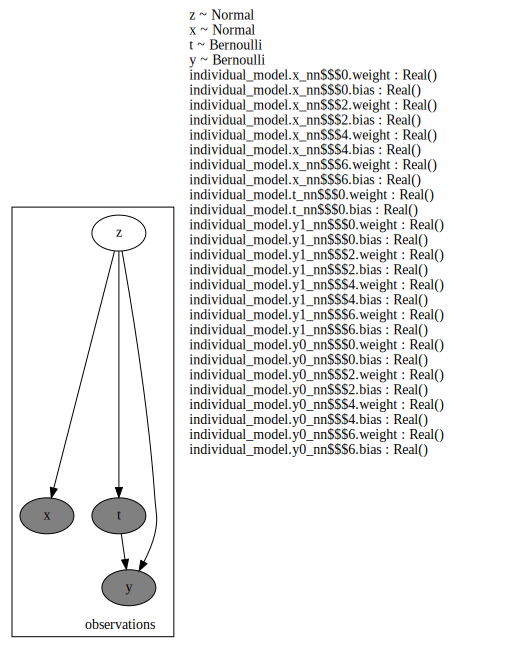

In [40]:
class CEVAE_MLE(PyroModule):
    def __init__(self, individual_model: ProxyConfounderModel):
        super().__init__()
        self.individual_model = individual_model

    def forward(self, x_obs, t_obs, y_obs):
        with pyro.condition(data=dict(x=x_obs, t=t_obs, y=y_obs)), \
                pyro.plate("observations", size=x_obs.shape[0], dim=-1):
            return self.individual_model()


mle_model = CEVAE_MLE(individual_model)
pyro.render_model(mle_model, model_args=(x, t ,y), render_distributions=True, render_params=True)

In [41]:
class PreWhitener(nn.Module):
    """
    Data pre-whitener.
    """
    def __init__(self, data):
        super().__init__()
        with torch.no_grad():
            loc = data.mean(0)
            scale = data.std(0)
            scale[~(scale > 0)] = 1.0
            self.register_buffer("loc", loc)
            self.register_buffer("inv_scale", scale.reciprocal())

    def forward(self, data):
        return (data - self.loc) * self.inv_scale

In [42]:
pyro.clear_param_store()
num_iterations = 1500 
batch_size = 100 
learning_rate = 1e-3 
learning_rate_decay = 0.1 
weight_decay = 1e-4
jit = False 

x_data = x.clone().detach()
t_data = t.clone().detach()
y_data = y.clone().detach()

guide = pyro.infer.autoguide.AutoNormal(mle_model)
adam = pyro.optim.Adam({"lr": learning_rate})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(mle_model, guide, adam, elbo)

for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, t_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x_data)))


[iteration 0001] loss: 129.4691
[iteration 0101] loss: 48.8817
[iteration 0201] loss: 46.8395
[iteration 0301] loss: 44.8455
[iteration 0401] loss: 42.9915
[iteration 0501] loss: 40.5664
[iteration 0601] loss: 38.1970
[iteration 0701] loss: 35.9802
[iteration 0801] loss: 34.1147
[iteration 0901] loss: 32.1258
[iteration 1001] loss: 30.2474
[iteration 1101] loss: 29.0302
[iteration 1201] loss: 27.7385
[iteration 1301] loss: 26.5841
[iteration 1401] loss: 25.8070


Now we can set up the extended model corresponding to the CATE:

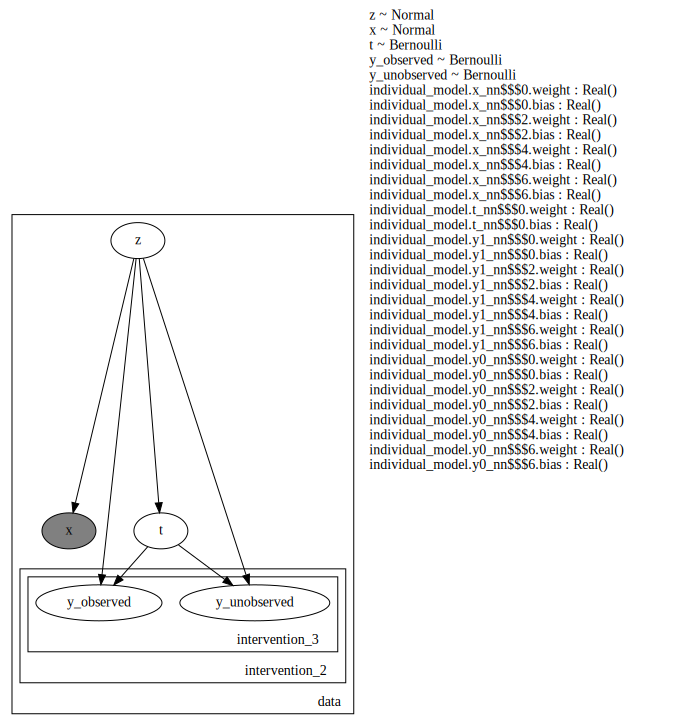

In [43]:
class CEVAE_CATE(PyroModule):
    def __init__(self, individual_model: ProxyConfounderModel):
        super().__init__()
        self.individual_model = individual_model

    def forward(self, x_pred):
        extended_model = do(actions = {"t": 0})(
                            do(actions = {"t": 1})(
                                pyro.plate("data", size=x_pred.shape[0], dim=-1)(
                                    condition(data={"x": x_pred})(self.individual_model))))
        with MultiWorldCounterfactual(-2):
            Ys_pred = extended_model()
        return Ys_pred


cate_model = CEVAE_CATE(individual_model)
pyro.render_model(cate_model, model_args=(x,), render_distributions=True, render_params=True)


The CATE is the expected return value of this new model, conditioning on
the observed covariates $X$. Any inference method available in Pyro
could be used to estimate it, including amortized variational inference
[@kingma2013auto] as in the original paper [@louizos2017causal].

In [45]:
pyro.clear_param_store()
num_iterations = 1500 
x_pred_data = x.clone().detach()
whiten = PreWhitener(x_pred_data)

cate_guide = pyro.infer.autoguide.AutoNormal(pyro.poutine.block(cate_model, hide=['t', 'y_observed', 'y_unobserved']))
adam = pyro.optim.Adam({"lr": learning_rate})
elbo = pyro.infer.TraceEnum_ELBO()
svi = pyro.infer.SVI(pyro.infer.config_enumerate(cate_model, "parallel"), cate_guide, adam, elbo)

for j in range(num_iterations):
    # calculate the loss and take a gradient step
    x_data = whiten(x_pred_data)
    loss = svi.step(x_pred_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x_pred_data)))

[iteration 0001] loss: 56.0073
[iteration 0101] loss: 46.9357
[iteration 0201] loss: 42.8684
[iteration 0301] loss: 40.4332
[iteration 0401] loss: 38.6539
[iteration 0501] loss: 36.8557
[iteration 0601] loss: 35.5130
[iteration 0701] loss: 34.1891
[iteration 0801] loss: 32.8429
[iteration 0901] loss: 31.6592
[iteration 1001] loss: 30.5747
[iteration 1101] loss: 29.4207
[iteration 1201] loss: 28.6107
[iteration 1301] loss: 27.4290
[iteration 1401] loss: 26.7384
